# Sketch Diffusion
### A Notebook to play with with diffusion on Googles Quickdraw Dataset using your own Laptop or in Google Colab
If running on Colab, make sure to select a GPU Runtime by selecting: Runtime - Change untime type - gpu. \
For Colab we also need to clone the GitHub Repository and install some required dependencies. If you run this locally, you can skip the next cell

In [ ]:
!git clone https://github.com/pitneitemeier/sketch_diffusion.git
%cd sketch_diffusion
!unzip -q car_64.zip
!pip install pytorch_lightning einops --quiet
!mkdir plots

In [25]:
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as T
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import einops

# Loading and analysing the dataset

In [26]:
from Sketchdata import SketchData, SingleImageData
IMG_SIZE = 32
CHANNELS = 1

transform = T.Compose([T.ToTensor(), T.Resize(IMG_SIZE)])
# to show the images, clamp them to [0,1] and invert the colors to have a white background
rev_transform = T.Compose([lambda x : 1 - torch.clamp(x, min=0, max=1)])
dataset = SketchData(['car_64'], transform)

def get_imgs(num_samples, dataset):
    return torch.stack([dataset[i] for i in range(num_samples)], dim=0)

Since we will be looking at lots of grids of Images, we define a helper method that allows us to visualize these.

In [27]:
def plot_grid(imgs, n_row):
    '''
    Function to plot a grid of images

    Parameters
    ----------
    imgs: torch.tensor
        expects a tensor of shape [b, c, h, w] of images
    n_row: int
        the number of images per row
    '''
    grid = torchvision.utils.make_grid(imgs, nrow=n_row)
    fig, ax = plt.subplots(figsize=(2 * n_row, 2 * imgs.shape[0] // n_row))
    ax.axis('off')
    ax.imshow(grid.permute(1,2,0).cpu(), cmap='gray')
    plt.close(fig)
    return fig

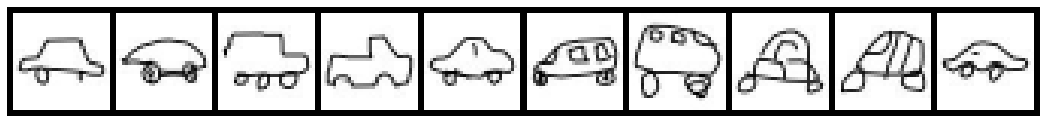

In [28]:
num_samples = 10
imgs = rev_transform(get_imgs(num_samples, dataset))
plot_grid(imgs, num_samples)

# Defining the diffusion process
A diffusion model is a process inspired by nonequilibrium thermodynamics (see [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](https://arxiv.org/abs/1503.03585)) and is based on the Markov chain depicted in the following figure:
\
![The markov chain that characterizes diffusion models. In the forward process Gaussian noise is added to an input image until signal is destroyed. In the reverse process, learned Gaussian transitions are used to subtract the noise.](images/diffusion_markov_chain.svg)
\
In this work we largely follow the process introduced by Ho et al. (See [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)).
Starting from an image $x_0 \sim q(x_0)$ from a ground truth distribution $q$, the \textit{forward process} gradually adds Gaussian noise to the image according to a variance schedule $\beta_1, \ldots, \beta_T$:
\begin{equation*}
    q(x_t | x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t I).
\end{equation*}
The \textit{reverse process} is another Markov chain with Gaussian transitions that aims to reverse the forward process using a learned mean $\mu_\theta(x_t,t)$. Starting from $x_T$ the process samples from
\begin{equation*}
    p_\theta(x_{t-1}|x_t)= \mathcal{N}(x_{t-1};\mu_\theta(x_t,t),\beta_t I).
\end{equation*}
To derive a suitable training loss, we first note that we can draw random samples from the forward process in a closed form, since the sum of two Gaussians with standard deviations $\sigma_1, \sigma_2$ is a Gaussian with standard deviation $\sqrt{\sigma_1^2 + \sigma_2^2}$. With $\epsilon_i, \epsilon \sim \mathcal{N}(0,1)$, $\alpha_t := \ 1-\beta_t$ and $\overline{\alpha}_t := \prod_{i=1}^t \alpha_i$ it follows that
\begin{align*}
    x_t &= \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t} \epsilon_t \\
    &= \sqrt{\alpha_t}(\sqrt{\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_{t-1}} \epsilon_{t-1}) + \sqrt{1-\alpha_t} \epsilon_t \\
    &= \sqrt{\overline{\alpha}_t} x_0 + \sqrt{1-\overline{\alpha}_t} \epsilon
\end{align*}
and therefore $q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\overline{\alpha}_t}x_0, (1-\overline{\alpha}_t)I)$. From this it is possible to derive the posteriors of the forward process using
\begin{align*}
    q(x_{t-1}|x_t,x_0) &= q(x_{t}|x_{t-1}, x_0) \frac{ q(x_{t-1}|x_0) }{q(x_t|x_0)} \\
    &= \mathcal{N}(x_{t-t}; \tilde{\mu}(x_t, x_0), \tilde{\beta}_t)\\
    \text{with } \tilde{\mu}(x_t, x_0) &:= \frac{\sqrt{\overline{\alpha}_{t-1}}\beta_t x_0 + \sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})x_t}{1-\overline{\alpha}_t} \\
    \text{and } \tilde{\beta}_t &:= \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_t} \beta_t \approx \beta_t
\end{align*}
With knowledge of the noise $\epsilon$ that was added in the forward process, we can simplify this using $x_t(x_0, \epsilon) = \sqrt{\overline{\alpha}_t} x_0 + \sqrt{1-\overline{\alpha}_t} \epsilon$ and $x_0 = \frac{1}{\sqrt{\overline{\alpha}_t}}(x_t(x_0,\epsilon) - \sqrt{1-\overline{\alpha}_t}\epsilon)$:
\begin{align*}
    \tilde{\mu}(x_t(x_0,\epsilon), x_0) = \frac{1}{\sqrt{\alpha_t}}(x_t(x_0,\epsilon) - \frac{\beta_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon).
\end{align*}
Since we want the reverse process to replicate the posterior probability, we can reparametrize $\mu_\theta(x_t,x_0)$ as 
\begin{align*}
    \mu_\theta(x_t,x_0) &= \tilde{\mu}(x_t, \frac{1}{\sqrt{\overline{\alpha}_t}}(x_t - \sqrt{1-\overline{\alpha}_t}\epsilon_\theta(x_t, t)))\\ 
    &= \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t, t))
\end{align*}
We can now define the training loss for a single sample as 
\begin{equation*}
    L(t, x_0, \epsilon) := \lVert{\epsilon - \epsilon_\theta(x_t(x_0,\epsilon), t)\rVert}^2.
\end{equation*}
Note that it is also possible to derive this loss from a negative log likelihood using the variational lower bound and Kullback-Leibler divergence (See [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)). During training we then evaluate this loss for a batch of $t \sim \text{Uniform}\{1, \ldots, T\}$, $\epsilon \sim \mathcal{N}(0,I)$ and $x_0 \sim q(x_0)$. The training process looks like this: 

![Training process](images/diffusion_training.svg)

To generate an image, we start from $x_T \sim \mathcal{N}(0,I)$ and then step through the full Markov chain in reverse. This process then looks like this:

![Sampling process](images/diffusion_sampling.svg)

### Noise schedule
First we define a class that saves the noise schedule $\beta_1, \ldots, \beta_T$ and provides methods to calculate $\overline{\alpha}_t$ and $\alpha_t$ in training and sampling.

In [29]:
class NoiseSchedule:
    '''
    Class that implements the noise schedule to use with the diffusion
    '''
    def __init__(self, betas):
        '''
        Parameters 
        ----------
        betas : torch.tensor
            the noise schedule to be used
        '''
        # calculate alpha_bar directly, since it is the only thing that is used in training
        self.device = 'cpu'
        self.alphas = 1. - betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        self.num_steps = self.alpha_bars.shape[0]

    def to(self, device):
        self.alpha_bars = self.alpha_bars.to(device)
        self.alphas = self.alphas.to(device)
        self.device = device
    
    def get_random_sample(self, x_0):
        '''
        Parameters
        ----------
        x_0 : torch.tensor
            The training images to generate samples for with shape [batch, channels, height, width]

        Returns
        -------
        t : torch.Tensor
            Random times in {0, 1/num_steps, ..., 1}
        alpha_bar_t : torch.tensor
            the cumulative product of the alphas for each timestep
        '''
        if self.device != x_0.device:
            self.to(x_0.device)
        # randomly choose a step in the diffusion chain to train on for each input image and retrieve the corresponding alpha_bar
        steps = torch.randint(low=0, high=self.num_steps, size=(x_0.shape[0],), device=x_0.device)
        return steps / self.num_steps, self.alpha_bars[steps]
    
    def get_sample(self, steps):
        '''
        Parameters
        ----------
        steps : torch.tensor of ints
            The steps in the diffusion chain to get samples for

        Returns
        -------
        t, alpha_t, alpha_bar_t
        '''
        assert (steps<self.num_steps).all(), f'maximum step should be smaller than the total number of steps'
        if self.device != steps.device:
          self.to(steps.device)
        return steps / self.num_steps, self.alphas[steps], self.alpha_bars[steps]

### Forward process
In the forward process, we want to access the image at a specific step in the diffusion chain. As derived above we do not have to step through the whole chain, but can use the fact that the sum of Gaussians is again a Gaussian. We define a method that implements this and then show an example of the forward process.

In [30]:
def noise_image(x_0, alpha_bar_t):
    '''
    Function to return a noisy version of the image according to the set noise schedule with
    x_t ~ N(sqrt(alpha_bar_t)x_0, sqrt(1-alpha_bar_t)I)

    Parameters
    ----------
    x_0 : torch.tensor
        the original input image with shape [batch, channels, height, width]
    alpha_bar : torch.tensor
        the accumulated noise schedule with shape [batch,]
    
    Returns
    -------
    x_t : torch.tensor
        the noisy image
    noise : torch.tensor
        the noise that was added to the image
    '''
    noise = torch.randn_like(x_0)
    alpha_bar_t = alpha_bar_t.view(-1,1,1,1)
    return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise, noise

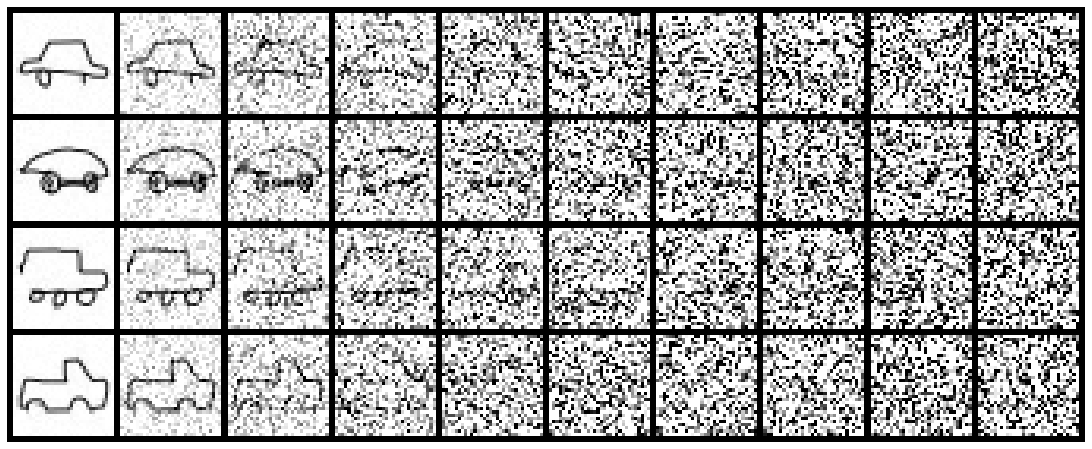

In [31]:
DIFFUSION_STEPS = 200
betas = torch.linspace(1e-4, 2e-2, DIFFUSION_STEPS)
noise_schedule = NoiseSchedule(betas)

# show an example of the noise process
show_steps = 10
num_samples=4
image = get_imgs(num_samples, dataset)
steps = torch.linspace(0,DIFFUSION_STEPS-1, show_steps, dtype=torch.int64)
x_0 = image.repeat_interleave(steps.shape[0],0)
steps = steps.repeat(image.shape[0],1,1,1)

t, _, alpha_bar_t = noise_schedule.get_sample(steps)
x_t, _ = noise_image(x_0, alpha_bar_t)
x_t = rev_transform(x_t)

plot_grid(x_t, show_steps)

### Reverse process

In [32]:
@torch.no_grad()
def denoise_step(model, x_t, t, alpha_t, alpha_bar_t):
    '''
    Function that does a single denoising step

    Returns
    -------
    x_{t-1} : torch.tensor
        the denoised images of shape [batch, channels, height, width]
    '''
    # reshape inputs for broadcasting
    alpha_t = alpha_t.view(-1,1,1,1)
    alpha_bar_t = alpha_bar_t.view(-1,1,1,1)

    sigma_t = torch.sqrt(1 - alpha_t)
    gamma_t = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
    noise = torch.randn_like(x_t)

    # do not add noise in the last step
    add_noise = (t != 0)

    return 1/torch.sqrt(alpha_t) * (x_t - gamma_t * model(x_t, t)) + add_noise * sigma_t * noise

@torch.no_grad()
def generate_images(model, num_examples, show_steps, img_size, channels):
    '''
    Function that implements Algorithm 2 of the paper 'Denoising Diffusion Probabilistic Models'

    Parameters
    ----------
    model : pl.LightningModule
        the diffusion model
    num_examples : int
        the number of images we want to generate
    show_steps : int
        the number of intermediate generation steps to show
    
    Returns
    -------
    imgs : torch.Tensor
        the sequence of images that was generated of shape [num_examples * (show_steps + 1), c, h, w]
    '''

    img =  torch.randn((num_examples, channels, img_size, img_size), device=model.device)
    imgs = []
    num_steps = model.noise_schedule.num_steps
    save_every = num_steps // show_steps if show_steps != 0 else 0
    for i in range(num_steps):
        if i % save_every  == 0 and show_steps!=0:
            imgs.append(img)
        t, alpha_t, alpha_bar_t = model.noise_schedule.get_sample(torch.tensor([num_steps - (i+1)], device=model.device))
        img = denoise_step(model, img, t, alpha_t, alpha_bar_t)
    imgs.append(img)
    imgs = torch.stack(imgs, dim=1).reshape(-1, *img.shape[1:])
    return imgs

# Defining the model
The model that we use here is a slightly modified UNet (see [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597))

![The model](images/unet_model.svg)
\

The ResNet Blocks consist of two 3x3 convolutions with stride 1 that are combined with Groupnorm and a residual connection. To encode the time input, a sinusoidal embedding as presented by Vaswani et al \cite{Vaswani2017} is used. The embedding is then added onto the image in the channel dimension (so each pixel in a channel gets the same embedding). Before down and upsampling, a self-attention layer is used. The downsampling consists of a 4x4 convolution with stride 2 and the upsampling is a 4x4 transposed convolution with stride 2. The activation in all layers is the GELU function.

In [33]:
def get_upsample(in_channels, out_channels):
    '''returns a class that doubles the image dimension using a transposed convolution'''
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

def get_downsample(channels):
    '''returns a class that halves the image dimension using a transposed convolution'''
    return nn.Conv2d(channels, channels, kernel_size=4, stride=2, padding=1)

def get_ConvNormBlock(in_channels, out_channels, num_groups, activation):
    '''returns a block of a 3x3 convolution followed by normalization and an activation'''
    assert out_channels % num_groups == 0, 'out_channels must be divisible by the number of groups'
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.GroupNorm(num_groups, out_channels),
        activation()
    )

In [34]:
# Generate a base time embedding that is fed into each layer and can then be adjusted to the number of channels in that layer
class BaseTimeEmbedding(nn.Module):
    '''A class that turns a batch of scalar time inputs into time embedding vectors in the channel dimension using sin and cosine embeddings.'''
    def __init__(self, base_time_dim, activation=nn.GELU) -> None:
        super().__init__()
        self.base_time_dim = base_time_dim
        self.layer_1 = nn.Linear(base_time_dim, base_time_dim)
        self.layer_2 = nn.Linear(base_time_dim, base_time_dim)
        self.activation = activation()

    def forward(self, t):
        # use a sin/cosine embedding similar to the 'attention is all you need' paper
        omega = 10000 ** ( - 2 / self.base_time_dim * torch.arange(1, self.base_time_dim // 2 + 1, 1, device=t.device) )
        t = t.unsqueeze(1)
        sines = torch.sin( omega * t )
        cosines = torch.cos( omega * t )
        t = torch.cat([sines, cosines], dim=1)
        t = self.activation(self.layer_1(t))
        t = self.layer_2(t)
        return t

class TimeResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, base_time_dim, activation=nn.GELU) -> None:
        super().__init__()

        self.time_embed = nn.Sequential(
            activation(),
            nn.Linear(base_time_dim, out_channels)
        )

        self.conv_norm_block_1 = get_ConvNormBlock(in_channels, out_channels, num_groups, activation=activation)
        self.conv_norm_block_2 = get_ConvNormBlock(out_channels, out_channels, num_groups, activation=activation)

        # since we allow for different number of input and output channels, a 1x1 convolution has to be used to bring 
        # input and output to the same shape
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, t):
        t = self.time_embed(t)
        h = self.conv_norm_block_1(x)
        h += t.reshape(*t.shape, 1, 1)
        h = self.conv_norm_block_2(h)
        return h + self.res_conv(x)

In [35]:
# Implementation of attention and linear attention taken from https://huggingface.co/blog/annotated-diffusion

class Attention(nn.Module):
    def __init__(self, in_channels, heads, head_channels):
        super().__init__()
        self.scale = head_channels ** -0.5
        self.heads = heads
        hidden_channels = head_channels * heads
        self.to_qkv = nn.Sequential(
            nn.GroupNorm(1, in_channels),
            nn.Conv2d(in_channels, hidden_channels * 3, 1, bias=False)
        )
        self.to_out = nn.Conv2d(hidden_channels, in_channels, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: einops.rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = torch.einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = torch.einsum("b h i j, b h d j -> b h i d", attn, v)
        out = einops.rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out) + x

class LinearAttention(nn.Module):
    def __init__(self, in_channels, heads, head_channels):
        super().__init__()
        self.scale = head_channels ** -0.5
        self.heads = heads
        hidden_channels = head_channels * heads
        self.to_qkv = nn.Sequential(
            nn.GroupNorm(1, in_channels),
            nn.Conv2d(in_channels, hidden_channels * 3, 1, bias=False)
        )

        self.to_out = nn.Conv2d(hidden_channels, in_channels, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: einops.rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = einops.rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out) + x

In [36]:
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, base_time_dim, activation=nn.GELU, attention=True) -> None:
        super().__init__()
        self.block_1 = TimeResNetBlock(in_channels, out_channels, num_groups, base_time_dim, activation=activation)
        self.block_2 = TimeResNetBlock(out_channels, out_channels, num_groups, base_time_dim, activation=activation)
        self.attention = LinearAttention(out_channels, 4, out_channels // 4) if attention else nn.Identity()
        self.downsample = get_downsample(out_channels)

    def forward(self, x, t):
        h = self.block_1(x, t)
        h = self.block_2(h, t)
        h = self.attention(h)

        # return downsampled input and the hidden state for residual connection in UNet
        return self.downsample(h), h

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, base_time_dim, activation=nn.GELU, attention=True) -> None:
        super().__init__()
        self.block_1 = TimeResNetBlock(2 * out_channels, out_channels, num_groups, base_time_dim, activation=activation)
        self.block_2 = TimeResNetBlock(out_channels, out_channels, num_groups, base_time_dim, activation=activation)
        self.attention = LinearAttention(out_channels, 4, out_channels // 4) if attention else nn.Identity()
        self.upsample = get_upsample(in_channels, out_channels)

    def forward(self, x, h, t):
        x = self.upsample(x)

        # doing a residual connection by concatenation 
        # to feed the input image back in at a later stage
        x = torch.cat([x,h], dim=1)
        x = self.block_1(x, t)
        x = self.block_2(x, t)
        x = self.attention(x)
        return x

class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, base_time_dim, activation=nn.GELU) -> None:
        super().__init__()
        self.block_1 = TimeResNetBlock(in_channels, out_channels, num_groups, base_time_dim, activation=activation)
        self.block_2 = TimeResNetBlock(out_channels, out_channels, num_groups, base_time_dim, activation=activation)
        self.attention = Attention(out_channels, 4, out_channels // 4)

    def forward(self, x, t):
        h = self.block_1(x, t)
        h = self.block_2(h, t)
        h = self.attention(h)
        return h

In [37]:
class UNet(pl.LightningModule):
    def __init__(self,
        channel_list,
        lr,
        patience,
        noise_schedule,
        optim=torch.optim.Adam
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.patience = patience
        self.noise_schedule = noise_schedule
        
        base_time_dim = max(channel_list)
        self.time_embedding = BaseTimeEmbedding(base_time_dim)

        num_layers = len(channel_list)
        self.downsample = nn.ModuleList([
            DownSampleBlock(channel_list[i], channel_list[i+1], num_groups=8, base_time_dim=base_time_dim) 
            for i in range(num_layers-2)
            ])

        self.upsample = nn.ModuleList([
            UpSampleBlock(channel_list[num_layers-(i+1)], channel_list[num_layers-(i+2)], num_groups=8, base_time_dim=base_time_dim) 
            for i in range(num_layers-2)
            ])
        
        self.middle = MidBlock(channel_list[-2], channel_list[-1], num_groups=8, base_time_dim=base_time_dim)
        self.final_layer = nn.Conv2d(channel_list[1], channel_list[0], kernel_size=3, padding=1)

    def forward(self, x, t):
        t = self.time_embedding(t)
        
        # save hidden states for residual connections to upsampling
        h_list = []
        for layer in self.downsample:
            x, h = layer(x, t)
            h_list.append(h)

        x = self.middle(x,t)

        for layer in self.upsample:
            h = h_list.pop()
            x = layer(x, h, t)

        out = self.final_layer(x)
        return out

    def training_step(self, x_0, _):
        t, alpha_bar_t = self.noise_schedule.get_random_sample(x_0)
        x_t, noise = noise_image(x_0, alpha_bar_t)
        predicted_noise = self(x_t, t)
        
        loss = F.mse_loss(noise, predicted_noise)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, x_0, _):
        t, alpha_bar_t = self.noise_schedule.get_random_sample(x_0)
        x_t, noise = noise_image(x_0, alpha_bar_t)
        predicted_noise = self(x_t, t)
        loss = F.mse_loss(noise, predicted_noise)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.2, patience=self.patience, verbose=True, min_lr=1e-6)
        return {'optimizer':optimizer, 'lr_scheduler':scheduler, 'monitor':'val_loss'}

# Training!

In [38]:
# split the data into training and validation data. We do not care about test data, since the model is tested by generating images
val_percent = .1
val_samples = int(len(dataset) * val_percent)
train_samples = len(dataset) - val_samples

train_dataset, val_dataset = random_split(dataset, [train_samples, val_samples])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

# alternatively for training on low end hardware (or cpus) we can use a single image of the dataset for training
# to do this, just uncomment the next line
#train_dataset = SingleImageData(dataset[0], epoch_len=5000)

To monitor the training in Tensorboard or by saving image files we write a Callback to pass to the Pytorch Lightning Trainer.

In [39]:
class GenerateCallback(pl.Callback):
    def __init__(self, num_examples, show_steps, every_n_epochs, img_size, channels, reverse_transform, plot_folder = None):
        super().__init__()
        self.num_examples = num_examples
        self.show_steps = show_steps
        self.img_size = img_size
        self.reverse_transform = reverse_transform
        self.channels=channels
        self.every_n_epochs = every_n_epochs
        self.plot_folder = plot_folder

    def on_train_epoch_end(self, trainer, model):
        if trainer.current_epoch % self.every_n_epochs == 0:
            with torch.no_grad():
                model.eval()
                imgs = generate_images(model, self.num_examples, self.show_steps, self.img_size, self.channels)
                imgs = self.reverse_transform(imgs)
                grid = torchvision.utils.make_grid(imgs,nrow=self.show_steps+1)
                model.train()
            # Plot and add to tensorboard
            trainer.logger.experiment.add_image(f"Generated images", grid, global_step=trainer.global_step)
            if self.plot_folder is not None:
                fig = plot_grid(imgs, self.show_steps+1)
                fig.savefig(self.plot_folder + 'gen_imgs_epoch_%s.jpeg'%trainer.current_epoch)

In [40]:
model = UNet(channel_list=[1,32,64,128], lr=5e-4, patience=5, noise_schedule=noise_schedule)

In [ ]:
model = UNet.load_from_checkpoint('')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if using a single image for training, remove the val_loader from the trainer and set num_examples=1
generate_callback = GenerateCallback(
    num_examples=10, 
    show_steps=5, 
    every_n_epochs=1, 
    img_size=IMG_SIZE, 
    channels=CHANNELS, 
    reverse_transform=rev_transform,
    plot_folder='plots'
)

trainer = pl.Trainer(
    accelerator=device,
    devices=1,
    max_epochs=30,
    callbacks=[generate_callback]
    )
trainer.fit(model, train_loader, val_loader)


We can look at some more images after the training has finished:

In [ ]:
num_imgs = 10
show_steps = 5

model.eval()
model.to(device)

imgs = generate_images(model, num_imgs, show_steps, IMG_SIZE, channels=CHANNELS)
imgs = rev_transform(imgs)
plot_grid(imgs, show_steps + 1)